In [1]:
import numpy as np
import pandas as pd
%matplotlib notebook
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import seaborn as sns
from celluloid import Camera
import ffmpeg
from scipy import stats
import math

import os
os.chdir(r'C:\Users\Shariq\MechProject')
os.getcwd()

'C:\\Users\\Shariq\\MechProject'

In [2]:
def simulate(horizon):
    '''
    horizon in hours
    Inventory stocks = 100 units (not %)
    deductions in integer units (not %)
    '''
    np.random.seed(0)
    
    if horizon:
        h_i = 100                      #initial level of container
        t_i = 0                     #intial time
        horizon = horizon * 60       #horizon time in minutes
        
        
        del_t_min = 30                  #minimum time interval between two consecutive del_h (= 30 mins)
        del_t_max = 60*2.5              #maximum time interval between two consecutive del_h (= 2.5 hours)
        
        times = [t_i]
        h = [h_i]
        del_hs = []
        del_ts = []
        
        while (h[-1] >= 0) & (times[-1] <= horizon) :
            del_t = np.random.randint(del_t_min, del_t_max)
            del_ts.append(del_t)
            del_h = int(0.1*np.random.uniform()*100) 
            del_h = del_h if del_h != 0 else 1
            del_hs.append(del_h)
            
            if (times[-1] + del_t <= horizon) & (h[-1] - del_h >= 0):
                
                times.append(times[-1] + del_t)
                h.append(h[-1] - del_h )
            
            else: break
                        
#         h = np.array(h)*100
        times = np.array(times) / 60
#         del_hs = np.array(del_hs)*100
        del_ts = np.array(del_ts) / 60
        h = np.round(h, 2); times = np.round(times, 2); del_hs = np.round(del_hs, 2); del_ts = np.round(del_ts, 2)
#         del_hs = np.where(del_hs, del_hs, stats.mode(del_hs))
        ts = np.cumsum(del_ts)
        return h, times, del_hs, del_ts, ts

In [3]:
horizon = 24
h, t, dh, dt, ts = simulate(horizon)
print(len(h), len(t), len(dh), len(dt), len(ts))

17 17 17 17 17


### plotting rect, kanban, barcode
#### loading kanban image and generating barcodes

In [40]:
import matplotlib.image as mpimg
import barcode
from barcode.writer import ImageWriter

def plot_rect_kanban(sim_fn=simulate, horizon=24):  
    h, t, dh, dt, ts = sim_fn(horizon)
    
    kanbancardloc = r'E:\Paste PD Files Here Only\Shariq_E\Sem 7\Project\kanban_image_from_pdf.png'
    kanbancard = mpimg.imread(kanbancardloc)
    
    fig, axs = plt.subplots(1, 2, gridspec_kw={'width_ratios': [1, 3]}, figsize=(8,5))
    
    ax = axs[0]
    ax2 = axs[1]
    plt.style.use('seaborn')
    
    camera = Camera(fig)
    
    # ax.set_xlabel('time')
    ax.set_ylabel('Inventory Level')
    ax.set_ylim([0,105])
    ax.set_xlim([0, 2])
    ax.get_xaxis().set_visible(False)
    ax2.set_axis_off()
    ax2.set_xlim([0,728])
    ax2.set_ylim([506, 0])
    ax2.set_title('KANBAN CARD')
#     ax2.grid('True')
    
    x = t
    y = h

    from matplotlib.patches import Rectangle
    width = 1.5
    lowerleft = 0.25
    
    for i in range(len(h)):
        
        #RECTANGLE
        rect = Rectangle((lowerleft,0), width, y[i], fill=True)
        ax.add_patch(rect)
        
        ax.hlines(y = y[i], xmin=0, xmax=width+lowerleft, colors='k', linestyles='dashed', label='current_level', lw=1)
        ax.annotate(text = f'Current level = {y[i]}', xy=(lowerleft, y[i]+1))

        camera.snap()
        
        #KANBAN CARD
        minute, hour = math.modf(ts[i])
        minute, hour = int(minute*60), int(hour)
    
        #GENERATE BARCODE
        barnumber = np.random.randint(low=1000000, high=9999999)
        filename = 'newbarcode'
        options = {'font_size': 15, 'text_distance':1, 'module_height':10}
        bars = barcode.get('code128', str(barnumber), writer=ImageWriter()) #Enter string as number to be coded
        barcodeimage = bars.save(filename, options) #Enter filename; saved as png
        #Load barcode image file
        barimg = mpimg.imread(filename + '.png')
        
        ax2.imshow(kanbancard)
        ax2.imshow(barimg, extent=[270, 475, 500, 330])
        
        ax2.text(s=f'Item {barnumber}', x=530, y=272,
                 fontsize=9.5, fontweight=1000, color='black', backgroundcolor='white')
        ax2.text(s=f'{barnumber}', x=15, y=440,
                 fontsize=12, fontweight=1000, color='black', backgroundcolor='white')
        
        
        ax2.text(s=f'{dh[i]}  ', x=495, y=160,
                 fontsize=13, color='black', backgroundcolor='white')
        ax2.text(s=f'Withdrawl At: 12/4/2020 {hour}:{minute}:00 \n\nRemaining Qty: {y[i] - dh[i]}',
                 x=20, y=290,
                 fontsize=12, color='black', backgroundcolor='white')

        #RECTANGLE
        rect = Rectangle((lowerleft,0), width, y[i], fill=True)
        ax.add_patch(rect)
        
        ax.hlines(y = y[i], xmin=0, xmax=width+lowerleft, colors='k', linestyles='dashed', label='current_level', lw=1)

        ax.annotate(text = f'Current level = {y[i]}', xy=(lowerleft, y[i]+1))
        camera.snap()
        
    animation = camera.animate(interval = 1500, repeat = False)
    animation.save('rectangle_with_kanban.html', writer='html')
    return animation



<IPython.core.display.Javascript object>


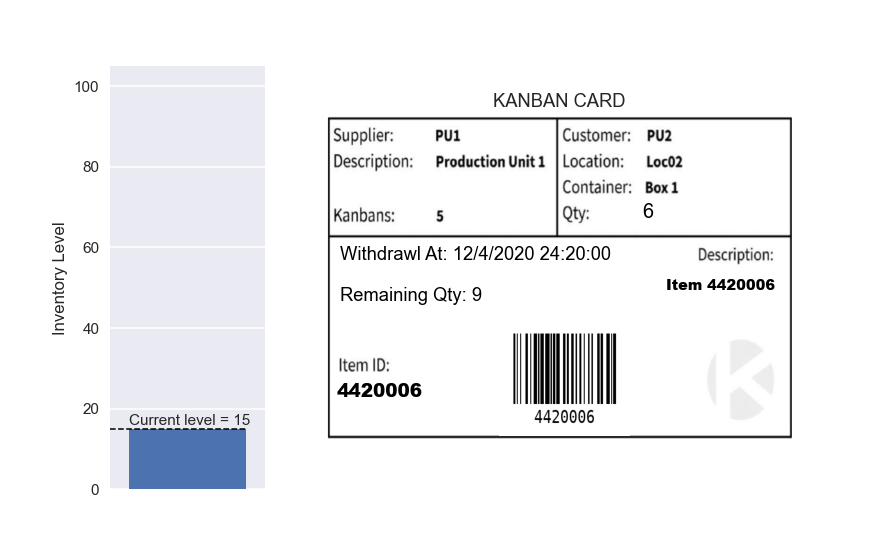

In [41]:
plot_rect_kanban()

### ffmpeg

In [43]:
import subprocess
inputloc = r"C:\Users\Shariq\MechProject\rectangle_with_kanban_frames\frame%07d.png"
outputloc = r"C:\Users\Shariq\MechProject\conatiner_kanban_barcode.webm"

frame_rate = 0.50
cmd = f'ffmpeg -framerate {frame_rate} -start_number 0000000 -i "{inputloc}" "{outputloc}"'
print(cmd)
subprocess.check_output(cmd, shell=True)

ffmpeg -framerate 0.5 -start_number 0000000 -i "C:\Users\Shariq\MechProject\rectangle_with_kanban_frames\frame%07d.png" "C:\Users\Shariq\MechProject\conatiner_kanban_barcode.webm"


b''